# Joint ptychography-tomography figure
> Georgios Varnavides*, Stephanie Ribet* et al.  
> 05/20/2024

This notebook reproduces the ptychographic-tomograpy figure (Fig. 13) in the manuscript [Iterative Phase Retrieval Algorithms for Scanning Transmission Electron Microscopy](https://arxiv.org/abs/2309.05250).

## Imports

In [1]:
import ase 
import abtem
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.ndimage import zoom,gaussian_filter

import cmasher as cmr
cmap = cmr.bubblegum

## abTEM Simulations

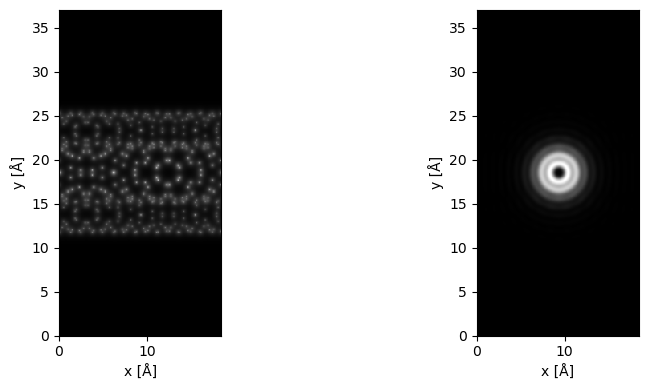

In [9]:
outer_cnt = ase.build.nanotube(12, 8, length=1)
inner_cnt = ase.build.nanotube(6, 4, length=1)
double_walled_cnt = outer_cnt + inner_cnt
double_walled_cnt.center(vacuum=0, axis=(0,1))
padding = double_walled_cnt.cell[2,2] - double_walled_cnt.cell[0,0]/2
double_walled_cnt.center(vacuum=padding, axis=(0,1))

# double_walled_cnt.rotate('x', 'z', rotate_cell=True)
# manual rotation
positions = double_walled_cnt.positions
positions_new = positions.copy()
positions_new[:,0] = positions[:,2]
positions_new[:,2] = positions[:,0]

double_walled_cnt = ase.Atoms(
    double_walled_cnt.symbols,
    positions = positions_new,
    cell=np.array([
        double_walled_cnt.cell[2,2],
        double_walled_cnt.cell[1,1],
        double_walled_cnt.cell[0,0]
    ])
)

double_walled_cnt_center = double_walled_cnt.cell.lengths()/2

static_potential = abtem.Potential(
    double_walled_cnt,
    gpts=(int(96*3*np.sqrt(2)/2),int(96*3*np.sqrt(2))),
    device="gpu",
    projection="infinite",
    parametrization="kirkland",
)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

static_potential.project().show(ax=ax1)
probe = abtem.Probe(semiangle_cutoff=25, energy=80e3, defocus=150,device="gpu")
probe.match_grid(static_potential)
probe.show(ax=ax2)

fig.tight_layout();

In [41]:
def obtain_tilt_series_cnt(angle_deg,v=[1,0,0]):
    atoms = double_walled_cnt.copy()
    atoms.rotate(angle_deg, v, center=double_walled_cnt_center)
    return atoms

def simulate_tilted_4dscan_cnt(angle_deg,v=[1,0,0],pbar=False):
    
    atoms = obtain_tilt_series_cnt(angle_deg,v)
    frozen_phonons = abtem.temperature.FrozenPhonons(atoms, 12, 0.075)
    
    potential = abtem.Potential(
        #frozen_phonons,  # uncomment this for a realistic simulation
        atoms,            # comment this for a realistic simulation
        gpts=(round(96*3*np.sqrt(2)/2),round(96*3*np.sqrt(2))),
        device="gpu",
        projection="infinite",
        parametrization="kirkland",
    )
    
    probe = abtem.Probe(semiangle_cutoff=25, energy=80e3, defocus=150,device="gpu")
    probe.match_grid(potential)
    
    pixelated_detector = abtem.PixelatedDetector(max_angle=None)
    
    grid_scan = abtem.GridScan(
        (0, potential.extent[1]/2-potential.extent[0]/2), (potential.extent[0],potential.extent[1]/2+potential.extent[0]/2),
        gpts=(36+1,36+1),
        endpoint=True
    )
    
    measurement = probe.scan(grid_scan, pixelated_detector, potential,pbar=pbar)
    sx,sy,qx,qy = measurement.shape
    crop_qx = (qx - 96)//2
    crop_qy = (qy - 96*2)//2

    array = measurement.array[:,:,crop_qx:crop_qx+96,crop_qy:crop_qy+96*2]
    array = array.reshape((37,37,96,96,2)).sum(-1)

    electrons_per_area = 1e4
    electrons_per_probe = electrons_per_area*np.array(grid_scan.sampling).prod()
    noisy_array = np.random.poisson(array*electrons_per_probe).astype(np.uint16)
    
    return noisy_array, measurement.calibrations[0].sampling, measurement.calibrations[2].sampling

In [42]:
array_noise_90, real_space_sampling, reciprocal_space_sampling = simulate_tilted_4dscan_cnt(90,pbar=True)

Potential:   0%|          | 0/75 [00:00<?, ?it/s]

Scan:   0%|          | 0/1369 [00:00<?, ?it/s]

In [43]:
measurements_noise = np.zeros((31,)+array_noise_90.shape)
measurements_noise[-1]=array_noise_90

for angle_index, angle in enumerate(tqdm(np.linspace(-90,90,30,endpoint=False))):
    measurements_noise[angle_index], _, _ = simulate_tilted_4dscan_cnt(angle)

  0%|          | 0/30 [00:00<?, ?it/s]

In [46]:
#data = np.fromfile("double_walled_cnt_4dstem_m90-p90_6deg_frozen-phonons_1e4.npy").reshape((31,37,37,96,96))
reciprocal_space_sampling = 2.248767617895552
real_space_sampling = 0.515803041652313

dcs = []
for tilt_index in range(measurements_noise.shape[0]):
    
    datacube = py4DSTEM.DataCube(measurements_noise[tilt_index])
    datacube.calibration.set_R_pixel_size(real_space_sampling)
    datacube.calibration.set_R_pixel_units('A')
    datacube.calibration.set_Q_pixel_size(reciprocal_space_sampling)
    datacube.calibration.set_Q_pixel_units('mrad')
    dcs.append(datacube)

dcs[0].calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    2.248767617895552
             R_pixel_size:    0.515803041652313
             Q_pixel_units:   mrad
             R_pixel_units:   A
             QR_flip:         False
)

## Single-Tilt Single-Slice Reconstruction

Best fit rotation forced to 0 degrees.
Transpose of intensities forced to False.
Normalizing amplitudes: 100%|███████████████████████████| 1369/1369 [00:00<00:00, 6650.42probe position/s]


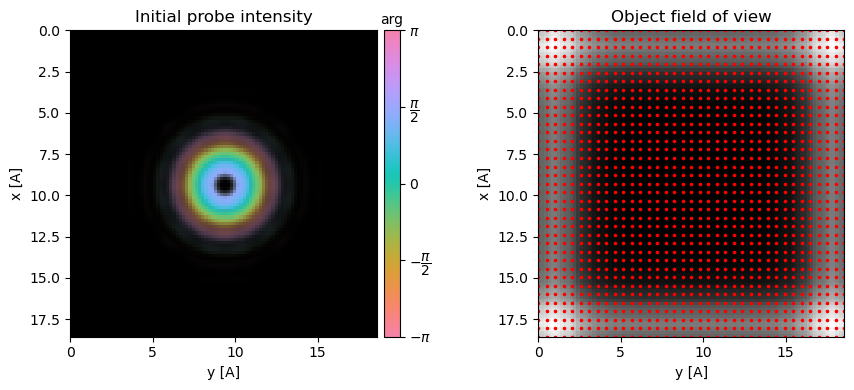

In [47]:
ptycho = py4DSTEM.process.phase.SingleslicePtychography(
    datacube=dcs[15],# zero-tilt dataset
    verbose=True,
    energy=80e3,
    semiangle_cutoff=25,
    defocus=150,
    storage='cpu',
    device='gpu',
    object_padding_px=(0,0),
).preprocess(
    force_com_rotation=0,
    force_com_transpose=False,
    plot_rotation=False,
    plot_center_of_mass = False,
)

Performing 32 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1 and step _size: 0.125.
Reconstructing object and probe: 100%|█████████████████████████████████| 32/32 [00:01<00:00, 21.77 iter/s]


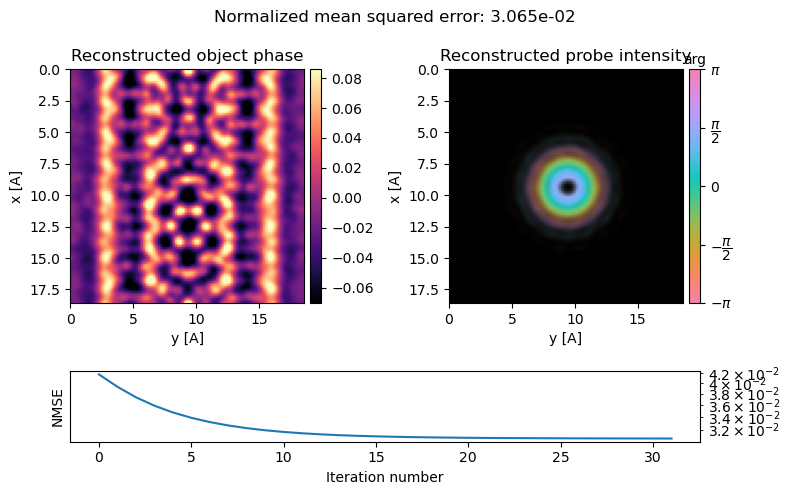

In [49]:
ptycho = ptycho.reconstruct(
    num_iter = 32,
    step_size=0.125,
    reset=True,
).visualize(
)

single_ptycho_object = ptycho.object.copy()

## Single-Tilt Multi-Slice Reconstruction

Best fit rotation forced to 0 degrees.
Transpose of intensities forced to False.
Normalizing amplitudes: 100%|███████████████████████████| 1369/1369 [00:00<00:00, 6618.48probe position/s]


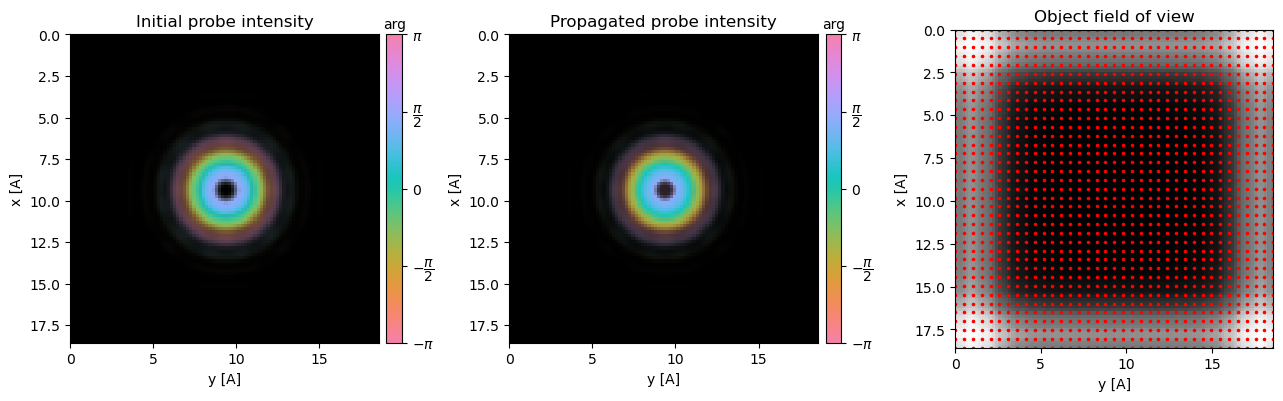

In [50]:
ms_ptycho = py4DSTEM.process.phase.MultislicePtychography(
    datacube=dcs[15],# zero-tilt dataset
    verbose=True,
    energy=80e3,
    num_slices=6,
    slice_thicknesses=ptycho.sampling[1]*ptycho._object_shape[1]/6,
    semiangle_cutoff=25,
    defocus=150,
    storage='cpu',
    device='gpu',
    object_padding_px=(0,0),
).preprocess(
    force_com_rotation=0,
    force_com_transpose=False,
    plot_rotation=False,
    plot_center_of_mass = False,
)

Performing 32 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1 and step _size: 0.125.
Reconstructing object and probe: 100%|█████████████████████████████████| 32/32 [00:04<00:00,  7.11 iter/s]


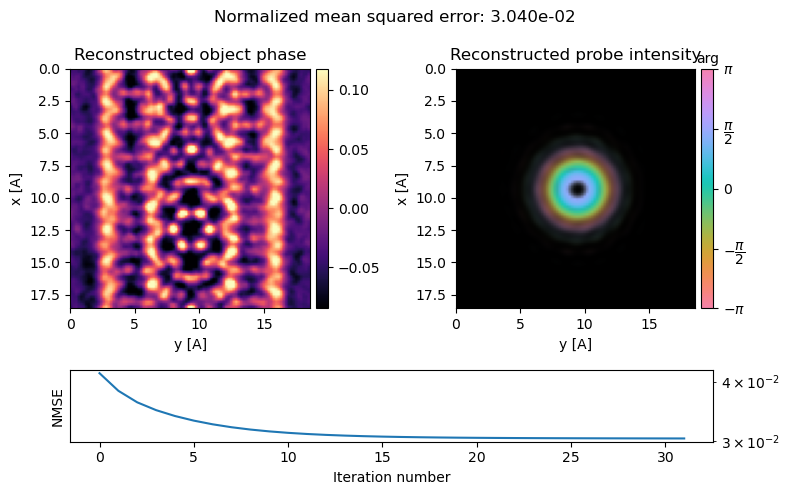

In [51]:
ms_ptycho = ms_ptycho.reconstruct(
    num_iter = 32,
    step_size=0.125,
    reset=True,
).visualize(
)

ms_ptycho_object = ms_ptycho.object.copy()

## 'Serial' Ptychographic Tomography

In [52]:
ptycho_sinogram = np.zeros((len(dcs),)+np.angle(ms_ptycho._crop_rotate_object_fov(ms_ptycho.object)).sum(0).shape)

for tilt_index in py4DSTEM.tqdmnd(len(dcs)):
    ms_ptycho = py4DSTEM.process.phase.MultislicePtychography(
        datacube=dcs[tilt_index],
        verbose=False,
        energy=80e3,
        num_slices=6,
        slice_thicknesses=ptycho.sampling[1]*ptycho._object_shape[1]/6,
        semiangle_cutoff=25,
        defocus=150,
        storage='cpu',
        device='gpu',
        object_padding_px=(0,0),
    ).preprocess(
        force_com_rotation=0,
        force_com_transpose=False,
        plot_center_of_mass = False,
        plot_probe_overlaps=False,
    ).reconstruct(
        progress_bar=False,
        num_iter = 32,
        step_size=0.125,
        reset=True,
    )
    
    ptycho_sinogram[tilt_index]= np.angle(ms_ptycho._crop_rotate_object_fov(ms_ptycho.object)).sum(0)

100%|█████████████████████████████████████████████████████████████████████| 31/31 [02:39<00:00,  5.14s/it]


In [53]:
import tomopy

angles_rad=np.linspace(np.deg2rad(-90),np.deg2rad(90),30,endpoint=False)
tomopy_recon = tomopy.recon(
    ptycho_sinogram[:-1].clip(0),
    angles_rad,
    algorithm='sirt',num_iter=100,
)
tomopy_recon = tomopy.circ_mask(tomopy_recon, axis=0)

tomopy_recon_missing = tomopy.recon(
    ptycho_sinogram[5:-5].clip(0),
    angles_rad[5:-4],
    algorithm='sirt',num_iter=100
)
tomopy_recon_missing = tomopy.circ_mask(tomopy_recon_missing, axis=0)

In [54]:
diffractogram_tomopy = np.fft.fftshift(
        np.abs(np.fft.fftn(tomopy_recon))
    )

diffractogram_tomopy_missing = np.fft.fftshift(
        np.abs(np.fft.fftn(tomopy_recon_missing))
    )

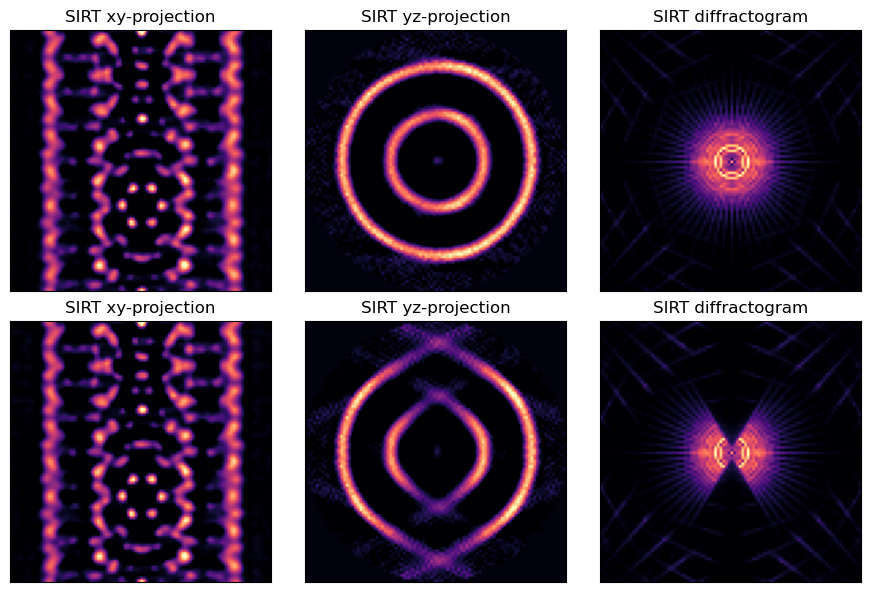

In [55]:
py4DSTEM.show(
    [
        [
            tomopy_recon.sum(1),
            tomopy_recon.sum(0),
            diffractogram_tomopy.sum(0)
        ],
        [
            tomopy_recon_missing.sum(1),
            tomopy_recon_missing.sum(0),
            diffractogram_tomopy_missing.sum(0)
        ]
    ],
    vmin=0.333,
    vmax=0.999,
    cmap='magma',
    ticks=False,
    title=[
        "SIRT xy-projection", "SIRT yz-projection", "SIRT diffractogram",
        "SIRT xy-projection", "SIRT yz-projection", "SIRT diffractogram"
    ],
    axsize=(3,3),
)

## Joint Ptychographic Tomography

In [56]:
from scipy.spatial.transform import Rotation

tilt_angles_around_x = np.linspace(90,-90,30,endpoint=False)
rotations = Rotation.from_rotvec(
    np.pad(
        tilt_angles_around_x[:,None],
        ((0,0),(0,2))
    ),
    degrees=True
)
orientation_matrices = rotations.as_matrix()

Preprocessing data: 100%|███████████████████████████████████████████████| 30/30 [00:07<00:00,  3.94tilt/s]


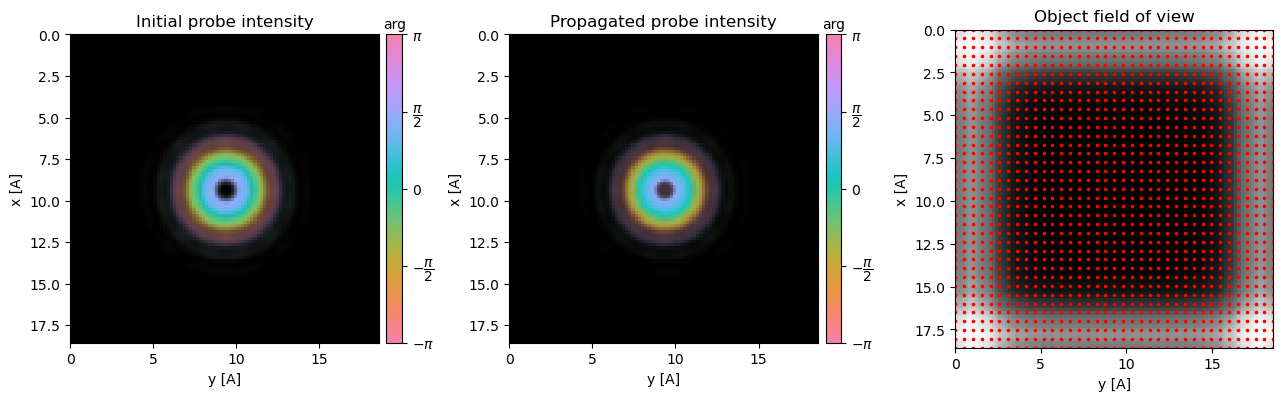

In [57]:
ptycho_tomo = py4DSTEM.process.phase.PtychographicTomography(
    datacube=dcs[:-1],
    verbose=True,
    energy=80e3,
    num_slices=24,
    tilt_orientation_matrices=orientation_matrices,
    semiangle_cutoff=25,
    defocus=150,
    storage='cpu',
    device='gpu',
    object_padding_px=(0,0),
).preprocess(
    plot_probe_overlaps=True,
    diffraction_patterns_rotate_degrees=0,
    diffraction_patterns_transpose=False
)

Performing 32 iterations using a potential object type, with the gradient-descent algorithm, with normalization_min: 1 and step _size: 0.125.
Reconstructing object and probe: 100%|█████████████████████████████████| 32/32 [08:09<00:00, 15.31s/ iter]


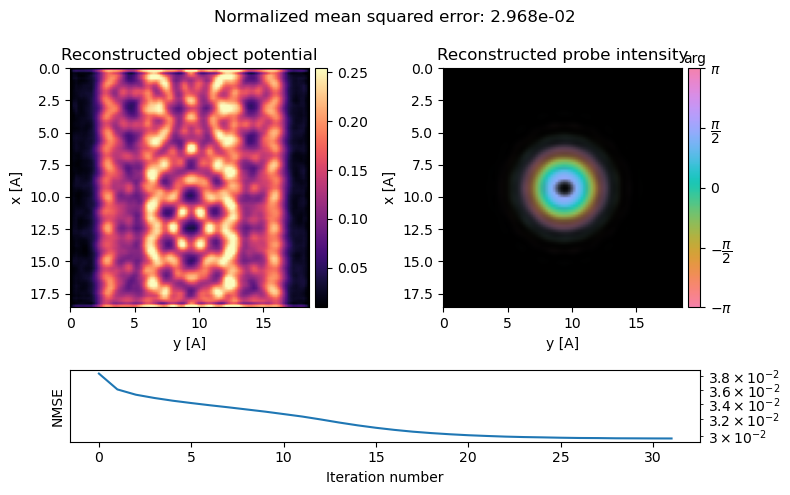

In [60]:
ptycho_tomo = ptycho_tomo.reconstruct(
    num_iter = 32,
    step_size=0.125,
    collective_measurement_updates = False,
    reset=True,
).visualize(
)

ptycho_tomo_sequential = ptycho_tomo.object.copy()

Performing 32 iterations using a potential object type, with the gradient-descent algorithm, with normalization_min: 1 and step _size: 0.125.
Reconstructing object and probe: 100%|█████████████████████████████████| 32/32 [08:11<00:00, 15.35s/ iter]


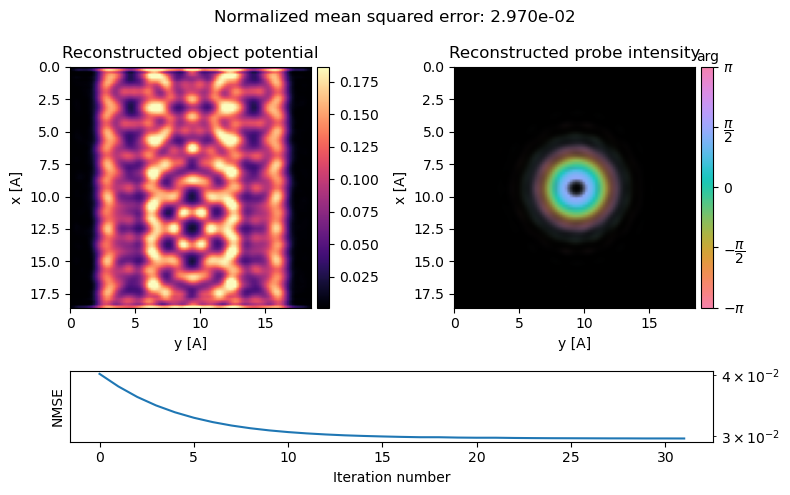

In [61]:
ptycho_tomo = ptycho_tomo.reconstruct(
    num_iter = 32,
    step_size=0.125,
    collective_measurement_updates=True,
    reset=True,
).visualize(
)

ptycho_tomo_collective = ptycho_tomo.object.copy()

In [63]:
diffractogram_sequential = np.fft.fftshift(
        np.abs(np.fft.fftn(ptycho_tomo_sequential))
    )

diffractogram_collective = np.fft.fftshift(
        np.abs(np.fft.fftn(ptycho_tomo_collective))
    )

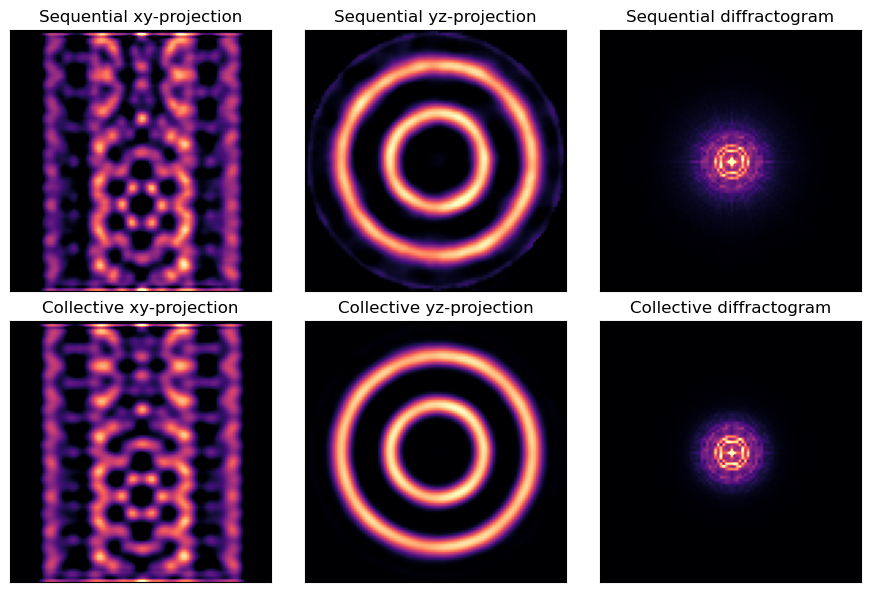

In [64]:
py4DSTEM.show(
    [
        [
            ptycho_tomo_sequential.sum(0),
            ptycho_tomo_sequential.sum(1),
            diffractogram_sequential.sum(1)
        ],
        [
            ptycho_tomo_collective.sum(0),
            ptycho_tomo_collective.sum(1),
            diffractogram_collective.sum(1)
        ],
    ],
    vmin=0.333,
    vmax=0.999,
    cmap='magma',
    ticks=False,
    title=[
        "Sequential xy-projection", "Sequential yz-projection", "Sequential diffractogram",
        "Collective xy-projection", "Collective yz-projection", "Collective diffractogram"
    ],
    axsize=(3,3),
)

## Missing Wedge

Preprocessing data: 100%|███████████████████████████████████████████████| 21/21 [00:05<00:00,  3.94tilt/s]


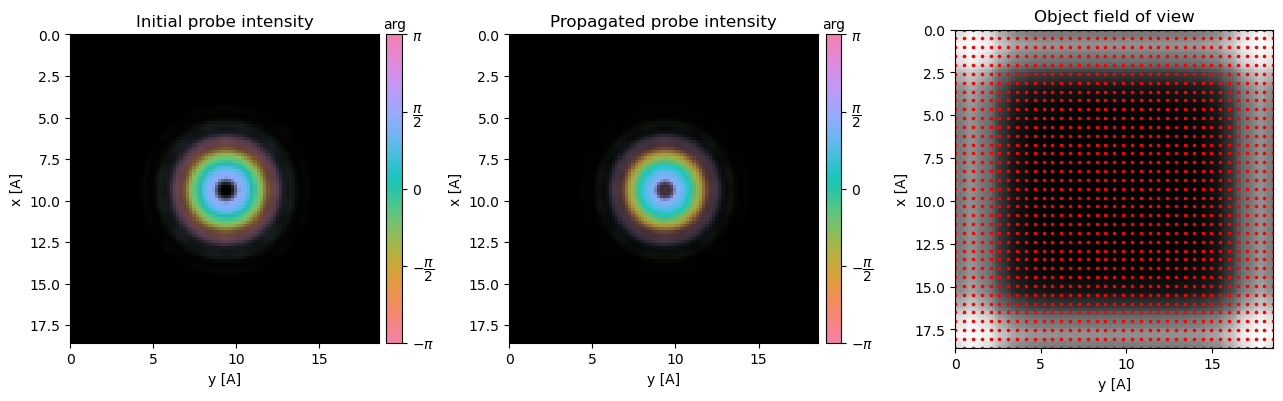

In [66]:
ptycho_tomo_missing = py4DSTEM.process.phase.PtychographicTomography(
    datacube=dcs[5:-5],
    verbose=True,
    energy=80e3,
    num_slices=24,
    tilt_orientation_matrices=orientation_matrices[5:-4],
    semiangle_cutoff=25,
    defocus=150,
    storage='cpu',
    device='gpu',
    object_padding_px=(0,0),
).preprocess(
    plot_probe_overlaps=True,
    diffraction_patterns_rotate_degrees=0,
    diffraction_patterns_transpose=False
)

Performing 32 iterations using a potential object type, with the gradient-descent algorithm, with normalization_min: 1 and step _size: 0.125.
Reconstructing object and probe: 100%|█████████████████████████████████| 32/32 [05:42<00:00, 10.70s/ iter]


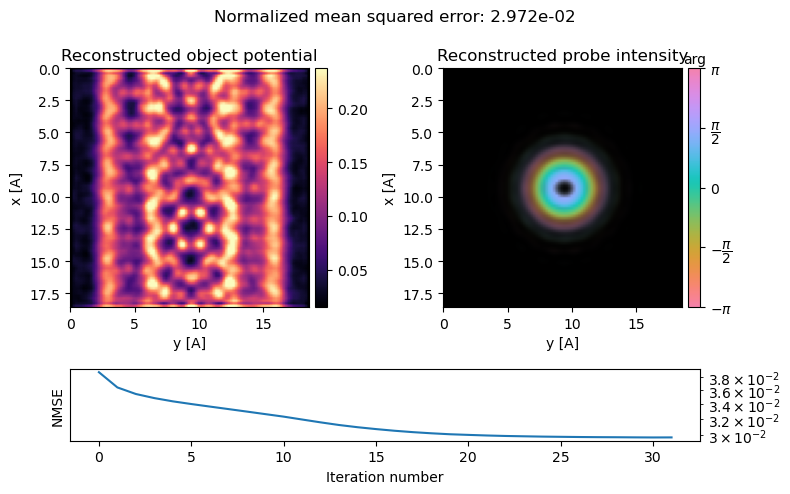

In [67]:
ptycho_tomo_missing = ptycho_tomo_missing.reconstruct(
    num_iter = 32,
    step_size=0.125,
    reset=True,
    collective_measurement_updates=False,
).visualize(
)

ptycho_tomo_missing_sequential = ptycho_tomo_missing.object.copy()

Performing 32 iterations using a potential object type, with the gradient-descent algorithm, with normalization_min: 1 and step _size: 0.125.
Reconstructing object and probe: 100%|█████████████████████████████████| 32/32 [05:43<00:00, 10.74s/ iter]


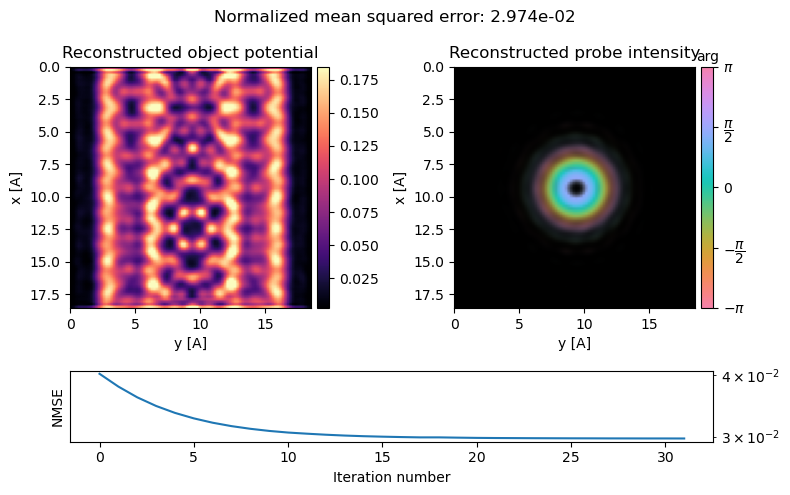

In [68]:
ptycho_tomo_missing = ptycho_tomo_missing.reconstruct(
    num_iter = 32,
    step_size=0.125,
    reset=True,
    collective_measurement_updates=True,
).visualize(
)

ptycho_tomo_missing_collective = ptycho_tomo_missing.object.copy()

In [69]:
diffractogram_missing_sequential = np.fft.fftshift(
        np.abs(np.fft.fftn(ptycho_tomo_missing_sequential))
    )

diffractogram_missing_collective = np.fft.fftshift(
        np.abs(np.fft.fftn(ptycho_tomo_missing_collective))
    )

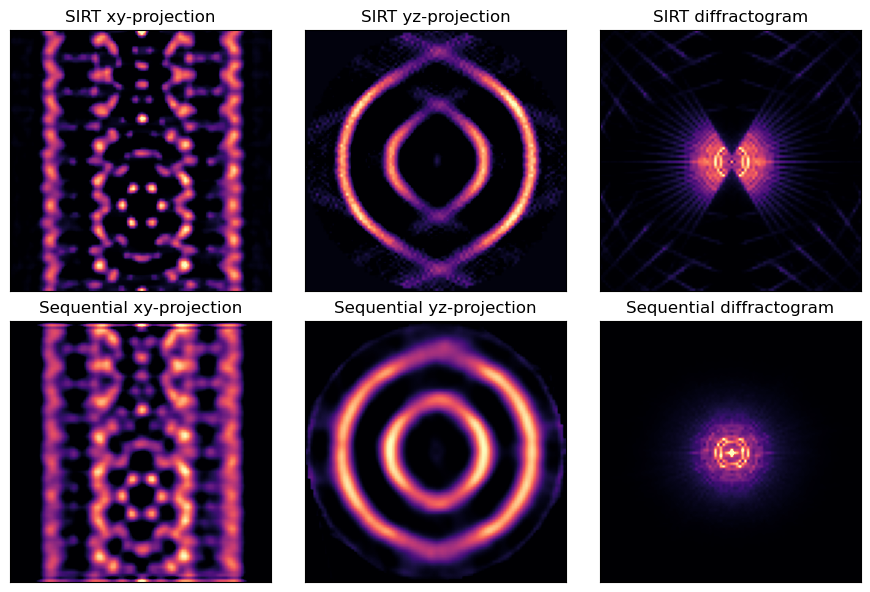

In [70]:
py4DSTEM.show(
    [
        [
            tomopy_recon_missing.sum(1),
            tomopy_recon_missing.sum(0),
            diffractogram_tomopy_missing.sum(0),
            
        ],
        [
            ptycho_tomo_missing_sequential.sum(0),
            ptycho_tomo_missing_sequential.sum(1),
            diffractogram_missing_sequential.sum(1)
        ],
    ],
    vmin=0.333,
    vmax=0.999,
    cmap='magma',
    ticks=False,
    title=[
        "SIRT xy-projection", "SIRT yz-projection", "SIRT diffractogram",
        "Sequential xy-projection", "Sequential yz-projection", "Sequential diffractogram"
    ],
    axsize=(3,3),
)

## Visualization

In [79]:
ptycho_sampling = ptycho.sampling[0]
upsampling_factor = 2
sigma = 1.0

gt_potential = abtem.Potential(
    double_walled_cnt,
    sampling=ptycho_sampling/upsampling_factor,
    slice_thickness=ptycho_sampling/upsampling_factor,
    projection="finite",
    parametrization="kirkland",
).build().array

gt_potential = gaussian_filter(gt_potential,upsampling_factor*sigma)
gt_potential = zoom(gt_potential,1/upsampling_factor)[48:-48,:,48:-48]

In [83]:
# Projections z

projection_gt = gt_potential.sum(0)
projection_tomopy = tomopy_recon.sum(1)
projection_sequential = np.flip(ptycho_tomo_sequential,axis=0).sum(0)
#projection_collective = np.flip(ptycho_tomo_collective,axis=0).sum(0)
projection_tomopy_missing = tomopy_recon_missing.sum(1)
projection_sequential_missing = np.flip(ptycho_tomo_missing_sequential,axis=0).sum(0)
#projection_collective_missing = np.flip(ptycho_tomo_missing_collective,axis=0).sum(0)

In [84]:
# Slices x

x_slice_gt = gt_potential[:,48-4:48+4].sum(1)
x_slice_tomopy = tomopy_recon[48-4:48+4].sum(0)
x_slice_sequential = np.flip(ptycho_tomo_sequential,axis=0)[:,48-4:48+4].sum(1)
#x_slice_collective = np.flip(ptycho_tomo_collective,axis=0)[:,48-4:48+4].sum(1)
x_slice_tomopy_missing = tomopy_recon_missing[48-4:48+4].sum(0)
x_slice_sequential_missing = np.flip(ptycho_tomo_missing_sequential,axis=0)[:,48-4:48+4].sum(1)
#x_slice_collective_missing = np.flip(ptycho_tomo_missing_collective,axis=0)[:,48-4:48+4].sum(1)

In [85]:
# FFT x

fft_gt = np.fft.fftshift(np.abs(np.fft.fftn(gt_potential))).sum(1)
fft_tomopy = np.fft.fftshift(np.abs(np.fft.fftn(tomopy_recon))).sum(0)
fft_sequential = np.fft.fftshift(np.abs(np.fft.fftn(np.flip(ptycho_tomo_sequential,axis=0)))).sum(1)
#fft_collective = np.fft.fftshift(np.abs(np.fft.fftn(np.flip(ptycho_tomo_collective,axis=0)))).sum(1)
fft_tomopy_missing = np.fft.fftshift(np.abs(np.fft.fftn(tomopy_recon_missing))).sum(0)
fft_sequential_missing = np.fft.fftshift(np.abs(np.fft.fftn(np.flip(ptycho_tomo_missing_sequential,axis=0)))).sum(1)
#fft_collective_missing = np.fft.fftshift(np.abs(np.fft.fftn(np.flip(ptycho_tomo_missing_collective,axis=0)))).sum(1)

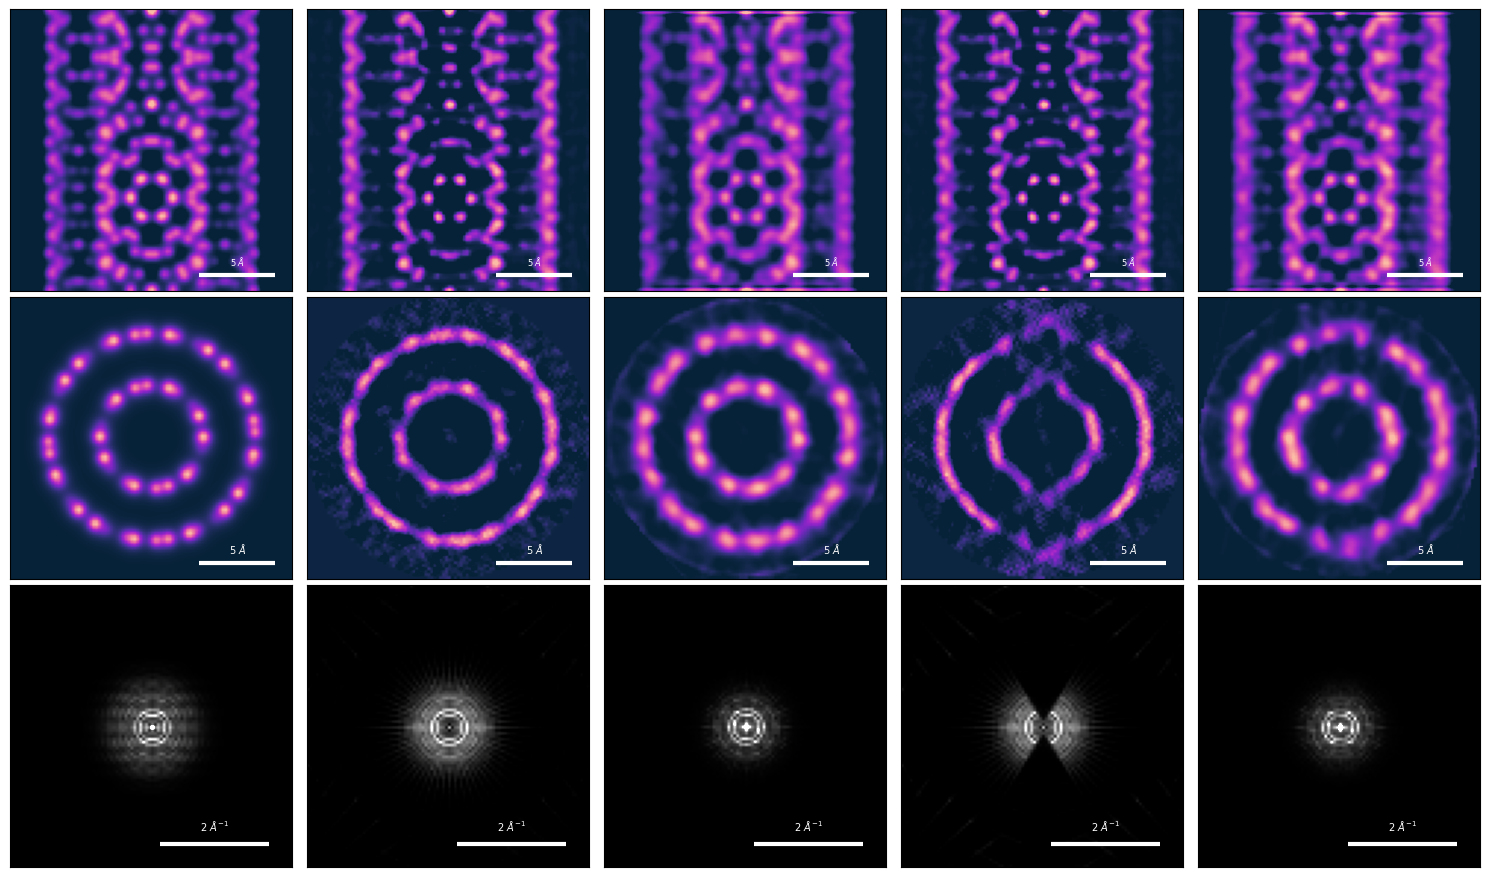

In [86]:
import cmasher as cmr

ptycho_tomo_figure, ptycho_tomo_axs = plt.subplots(3,5, figsize=(15,9))

py4DSTEM.show(
    [
        projection_gt,
        projection_tomopy,
        projection_sequential,
        projection_tomopy_missing,
        projection_sequential_missing
    ],
    vmin=0.333,
    vmax=0.999,
    cmap=cmr.bubblegum,
    ticks=False,
    scalebar={'length':5,'width':3}, 
    pixelsize=overlap_tomo.sampling[0], 
    pixelunits='$\AA$',
    figax=(ptycho_tomo_figure,ptycho_tomo_axs[0])
)

py4DSTEM.show(
    [
        x_slice_gt,
        x_slice_tomopy,
        x_slice_sequential,
        x_slice_tomopy_missing,
        x_slice_sequential_missing
    ],
    vmin=0.333,
    vmax=0.999,
    cmap=cmr.bubblegum,
    ticks=False,
    scalebar={'length':5,'width':3}, 
    pixelsize=overlap_tomo.sampling[0], 
    pixelunits='$\AA$',
    figax=(ptycho_tomo_figure,ptycho_tomo_axs[1])
)

py4DSTEM.show(
    [
        fft_gt,
        fft_tomopy,
        fft_sequential,
        fft_tomopy_missing,
        fft_sequential_missing
    ],
    vmin=0.5,
    vmax=0.999,
    cmap=cmr.neutral,
    power=1.5,
    ticks=False,
    scalebar={'length':2,'width':3}, 
    pixelsize=overlap_tomo._reciprocal_sampling[0], 
    pixelunits='$\AA^{-1}$',
    figax=(ptycho_tomo_figure,ptycho_tomo_axs[2])
)

ptycho_tomo_figure.tight_layout()

## Postprocessing
> Done in Inkscape